In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

## 전처리

In [123]:
train_data = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv', index_col = 'datetime')
test_data = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv', index_col = 'datetime')
train_data.index = pd.to_datetime(train_data.index)
test_data.index = pd.to_datetime(test_data.index)

In [86]:
train_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [124]:
print(train_data['weather'].value_counts())
print(test_data['weather'].value_counts())

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64
weather
1    4221
2    1710
3     560
4       2
Name: count, dtype: int64


In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [125]:
#한번에 전처리
def preprocess_train(data, submit_data):
    def map_hour_to_rank(data, submit_data):
        hour_ranking = data.groupby('hour')['count'].mean().rank(method='dense', ascending=False).astype(int).to_dict()
        data['hour_rank'] = data['hour'].map(hour_ranking)
        submit_data['hour_rank'] = submit_data['hour'].map(hour_ranking)
        data = data.drop(columns=['hour'])
        submit_data = submit_data.drop(columns=['hour'])
        return data, submit_data
    
    def map_year_to_rank(data, submit_data):
        year_ranking = {2011:2, 2012:1}
        data['year_rank'] = data['year'].map(year_ranking)
        submit_data['year_rank'] = submit_data['year'].map(year_ranking)
        data = data.drop(columns=['year'])
        submit_data = submit_data.drop(columns=['year'])
        return data, submit_data
    
    def map_month_to_rank(data, submit_data):
        month_ranking = data.groupby('month')['count'].mean().rank(method='dense', ascending=False).astype(int).to_dict()
        data['month_rank'] = data['month'].map(month_ranking)
        submit_data['month_rank'] = submit_data['month'].map(month_ranking)
        data = data.drop(columns=['month'])
        submit_data = submit_data.drop(columns=['month'])
        return data, submit_data
    
    def scaling_weather_data(data):
        scaler_s = StandardScaler()
        scaler_r = RobustScaler()
        data['temp'] = scaler_s.fit_transform(data['temp'].values.reshape(-1, 1))
        data['humidity'] = scaler_r.fit_transform(data['humidity'].values.reshape(-1, 1))
        data['windspeed'] = scaler_r.fit_transform(data['windspeed'].values.reshape(-1, 1))
        return data
    
    def remove_outlier(data):
        data = data[data['weather'] != 4]
        return data
    
    #X
    temp_data = data.drop(columns=['casual', 'registered']) #only for train data
    temp_submit_data = submit_data
    
    temp_data = temp_data.drop(columns=['atemp', 'season'])
    temp_submit_data = temp_submit_data.drop(columns=['atemp', 'season'])
    
    temp_data['year'] = temp_data.index.year
    temp_data['month'] = temp_data.index.month
    temp_data['hour'] = temp_data.index.hour
    temp_submit_data['year'] = temp_submit_data.index.year
    temp_submit_data['month'] = temp_submit_data.index.month
    temp_submit_data['hour'] = temp_submit_data.index.hour
    
    temp_data, temp_submit_data = map_hour_to_rank(temp_data, temp_submit_data)
    temp_data, temp_submit_data = map_year_to_rank(temp_data, temp_submit_data)
    temp_data, temp_submit_data = map_month_to_rank(temp_data, temp_submit_data)
    
    temp_data = scaling_weather_data(temp_data)
    temp_submit_data = scaling_weather_data(temp_submit_data)
    
    temp_data = remove_outlier(temp_data)
    #temp_submit_data = remove_outlier(temp_submit_data)
    
    #Y #only for train data
    temp_data = temp_data[[col for col in temp_data.columns if col != 'count'] + ['count']]
    temp_data['count'] = np.log(temp_data['count'])
    
    return temp_data, temp_submit_data

In [126]:
preprocessed_data, preprocessed_submit_data = preprocess_train(train_data, test_data)

In [127]:
preprocessed_data.to_csv('preprocessed_train.csv')
preprocessed_submit_data.to_csv('preprocessed_test.csv')

### 회귀 모델링

In [128]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import xgboost

In [129]:
train_data = pd.read_csv('/kaggle/working/preprocessed_train.csv', index_col='datetime')
test_data = pd.read_csv('/kaggle/working/preprocessed_test.csv', index_col='datetime')

In [130]:
train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]
display(train_x)
display(train_y)

,holiday,workingday,weather,temp,humidity,windspeed,hour_rank,year_rank,month_rank
datetime,,,,,,,,,
2011-01-01 00:00:00,0,0,1,-1.333661,0.633333,-1.300268,19,2,12
2011-01-01 01:00:00,0,0,1,-1.438907,0.600000,-1.300268,20,2,12
2011-01-01 02:00:00,0,0,1,-1.438907,0.600000,-1.300268,21,2,12
2011-01-01 03:00:00,0,0,1,-1.333661,0.433333,-1.300268,23,2,12
2011-01-01 04:00:00,0,0,1,-1.333661,0.433333,-1.300268,24,2,12
...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,1,-0.596935,-0.400000,1.300938,5,1,9
2012-12-19 20:00:00,0,1,1,-0.702182,-0.166667,0.200402,10,1,9
2012-12-19 21:00:00,0,1,1,-0.807428,-0.033333,0.200402,15,1,9


datetime
2011-01-01 00:00:00    2.772589
2011-01-01 01:00:00    3.688879
2011-01-01 02:00:00    3.465736
2011-01-01 03:00:00    2.564949
2011-01-01 04:00:00    0.000000
                         ...   
2012-12-19 19:00:00    5.817111
2012-12-19 20:00:00    5.484797
2012-12-19 21:00:00    5.123964
2012-12-19 22:00:00    4.859812
2012-12-19 23:00:00    4.477337
Name: count, Length: 10885, dtype: float64

In [131]:
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=1)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(8708, 9) (2177, 9) (8708,) (2177,)


In [132]:
def RMSLE(y_true, y_pred):
    y_true = np.exp(y_true)
    y_pred = np.exp(y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [133]:
model = xgboost.XGBRegressor(objective='reg:squaredlogerror')
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [134]:
preds = model.predict(x_valid)
preds = np.array(list(map(lambda x:-x if x<0 else x, preds)))
print(RMSLE(y_valid, preds))

0.34923967904321634


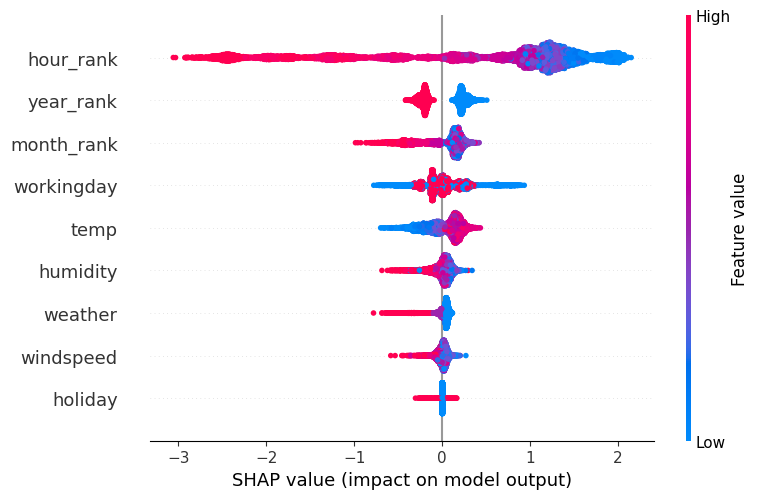

In [135]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

In [136]:
pred = model.predict(test_data)
pred = np.array(list(map(lambda x:-x if x<0 else x, pred)))
pred

array([2.199784  , 0.9889708 , 0.44716027, ..., 5.178084  , 4.861555  ,
       4.656869  ], dtype=float32)

In [137]:
pred = np.array(list(map(lambda x:int(np.exp(x)), pred)))

In [138]:
pred

array([  9,   2,   1, ..., 177, 129, 105])

In [139]:
submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')
submission['count'] = pred
submission

,datetime,count
0,2011-01-20 00:00:00,9
1,2011-01-20 01:00:00,2
2,2011-01-20 02:00:00,1
3,2011-01-20 03:00:00,1
4,2011-01-20 04:00:00,1
...,...,...
6488,2012-12-31 19:00:00,392
6489,2012-12-31 20:00:00,298
6490,2012-12-31 21:00:00,177
6491,2012-12-31 22:00:00,129


In [141]:
submission.to_csv('sampleSubmission-v2.csv', index=False)